# Lab 4

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
October 22, 2023  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in dataset and confirm df is populated
data = 'acs2017_census_tract_data.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(74001, 37)


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [2]:
# Look at missing values
print(df.isna().sum())
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64
Number of rows with missing values: 1283


In [3]:
import copy

df_dropped = copy.deepcopy(df) # Create deep copy of df to avoid overwriting
df_dropped.dropna(axis='index',inplace=True)

# Reset index of df to keep order consistent
df_dropped.reset_index(drop=True, inplace=True)

print('df shape before dropping:', df.shape)
print('df shape after dropping:', df_dropped.shape)
print(df_dropped.isna().sum())
print('Number of rows with missing values:', df_dropped.isnull().any(axis=1).sum())

df shape before dropping: (74001, 37)
df shape after dropping: (72718, 37)
TractId             0
State               0
County              0
TotalPop            0
Men                 0
Women               0
Hispanic            0
White               0
Black               0
Native              0
Asian               0
Pacific             0
VotingAgeCitizen    0
Income              0
IncomeErr           0
IncomePerCap        0
IncomePerCapErr     0
Poverty             0
ChildPoverty        0
Professional        0
Service             0
Office              0
Construction        0
Production          0
Drive               0
Carpool             0
Transit             0
Walk                0
OtherTransp         0
WorkAtHome          0
MeanCommute         0
Employed            0
PrivateWork         0
PublicWork          0
SelfEmployed        0
FamilyWork          0
Unemployment        0
dtype: int64
Number of rows with missing values: 0


In [4]:
# Encode all string data as integers
# Note: label encoding should not be used for state and county in general; these should be one-hot encoded later
# However, the lab specifies to only encode as ints for now
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_dropped['State'] = label_encoder.fit_transform(df_dropped['State'])
df_dropped['County'] = label_encoder.fit_transform(df_dropped['County'])

print('State values after label encoding:', df_dropped['State'].unique())
print('County values after label encoding:', df_dropped['County'].unique())

State values after label encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48
 49 50 51 39]
County values after label encoding: [  89   97  108 ... 1818 1929 1938]


For now, we will keep the County variable in the dataframe. County might not be a strong predictor for child poverty rates,  and because we are only label encoding right now, we have enforced an ordinality that is not intended. However, we can always remove it from the dataframe later if we find it uneccessary or unhelpful, so for now we will keep it in.

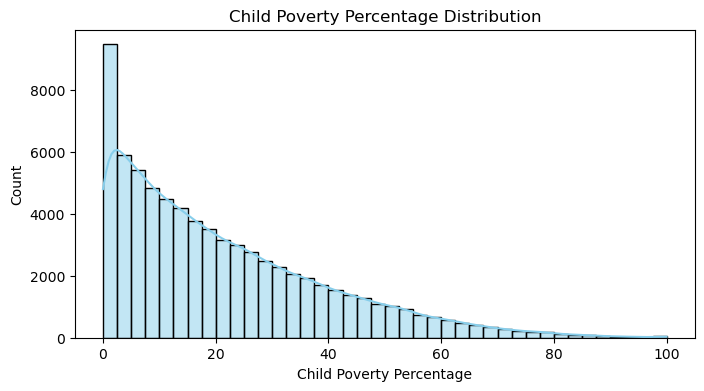

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(df_dropped['ChildPoverty'], bins=40, kde=True, color='skyblue')
plt.xlabel('Child Poverty Percentage')
plt.ylabel('Count')
plt.title('Child Poverty Percentage Distribution')
plt.show()

In [6]:
# TODO: Wait do we still need this block?

# TODO: Potentially we should change the bin edges to be more evenly distributed as you can see in the graph I made above.
# We could do 0-10, 10-20, 20-30, and 30+ 

# Define the bin edges and labels for the categories
bin_edges = [0, 25, 50, 75, 100]
bin_labels = [0, 1, 2, 3]

# determine better split for rates of child poverty

df_processed = df_dropped.copy()

# Use the cut function to create the categorical column
df_processed['ChildPoverty'] = pd.cut(df_processed['ChildPoverty'], bins=bin_edges, labels=bin_labels, include_lowest=True)

child_poverty_counts = df_processed['ChildPoverty'].value_counts()
num_records = 72718

print(df_processed['ChildPoverty'].value_counts())
print('Percentage of child poverty groupings in dataset:')
print('Low:', f"{(child_poverty_counts[0] / num_records) * 100:.2f}%")
print('Moderate:', f"{(child_poverty_counts[1] / num_records) * 100:.2f}%")
print('High:', f"{(child_poverty_counts[2] / num_records) * 100:.2f}%")
print('Very High:', f"{(child_poverty_counts[3] / num_records) * 100:.2f}%")

0    47825
1    18400
2     5635
3      858
Name: ChildPoverty, dtype: int64
Percentage of child poverty groupings in dataset:
Low: 65.77%
Moderate: 25.30%
High: 7.75%
Very High: 1.18%


In [7]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = df_processed.drop('ChildPoverty', axis=1).values
y = df_processed['ChildPoverty'].astype('uint8').values # TODO: "You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. "

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_train.dtype)
print(y_train.dtype)
print(X_test.shape)
print(y_test.shape)

(58174, 36)
(58174,)
float64
uint8
(14544, 36)
(14544,)


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


class_distribution = pd.Series(y_train_smote).value_counts()
print('class distribution after SMOTE:', '\n', class_distribution)

print(X_train_smote.shape)
print(y_train_smote.shape)
print(class_distribution.shape)


class distribution after SMOTE: 
 0    38260
1    38260
2    38260
3    38260
dtype: int64
(153040, 36)
(153040,)
(4,)


We chose to use SMOTE (Synthetic Minority Over-sampling Technique) to balance our data because our dataset exhibited a significant class imbalance, with a notably smaller number of instances in the minority classes. In such imbalanced datasets, standard machine learning models may struggle to accurately classify minority classes due to the limited number of examples available for training. SMOTE provides an effective solution by creating synthetic samples for the minority classes, effectively expanding the dataset and making it more balanced. This technique not only mitigates the risk of model bias towards the majority class but also enhances the model's ability to learn from all classes, ultimately leading to improved classification performance.

Balancing the dataset is typically done on the training set only, and not on the testing set. The reason for this is related to the objectives of model training and evaluation. Here's why:

1. **Training Set Balancing**:

   - Balancing the training set helps the machine learning model learn from all classes effectively, particularly when dealing with imbalanced data.
   - In an imbalanced dataset, the model can become biased toward the majority class. By balancing the training set, you ensure that the model is exposed to roughly equal amounts of data from each class, helping it learn the underlying patterns and relationships in all classes.

2. **Testing Set Unaltered**:

   - The testing set is intended to simulate how well your model will perform on real-world, unseen data.
   - Balancing the testing set would artificially alter the class distribution, which doesn't reflect the actual class distribution you would encounter in practice.
   - Balancing the testing set can lead to overly optimistic evaluation results because the model has been trained on a different class distribution.

3. **Realistic Evaluation**:

   - By keeping the testing set unaltered, you ensure that the model's performance evaluation reflects its ability to generalize to the actual, imbalanced distribution that you will encounter in real-world scenarios.
   - This realistic evaluation is crucial for understanding how well your model will perform in practice and making meaningful decisions about its deployment.

In summary, balancing is a preprocessing step that is applied to the training set to help the model learn effectively. The testing set should remain untouched to provide a realistic assessment of your model's performance under real-world class distribution conditions.

## Two-Layer Perceptron
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

[.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.  
[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.   
[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  
[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.   

In [9]:
 # Base two layer perceptron with vectorized back propagation
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [10]:
# Add mini batching

from sklearn.metrics import accuracy_score
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                # simple momentum calculations
                
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
    

In [11]:
# Implement cross entropy loss
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3+1e-7)+(1-Y_enc)*np.log(1-A3+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
        
    

In [12]:
# Add Glorot initialization to finalize TLP
class TLP_Vec_Mini_Cross_Glorot(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

In [13]:
# Helper function to print accuracies of nn classification
def print_accuracies(nn,X_train,y_train,X_test,y_test):
    
    yhat = nn.predict(X_train)
    print('Resubstitution accuracy:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))

In [16]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':100, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn = TLP_Vec_Mini_Cross_Glorot(**vals)
%time nn.fit(X_train, y_train, print_progress=10, XY_test=(X_test, y_test))
print_accuracies(nn,X_train,y_train,X_test,y_test)

Epoch: 100/100

CPU times: total: 3min 27s
Wall time: 53.7 s
Resubstitution accuracy: 0.6576821260356861
Validation acc: 0.6576595159515951


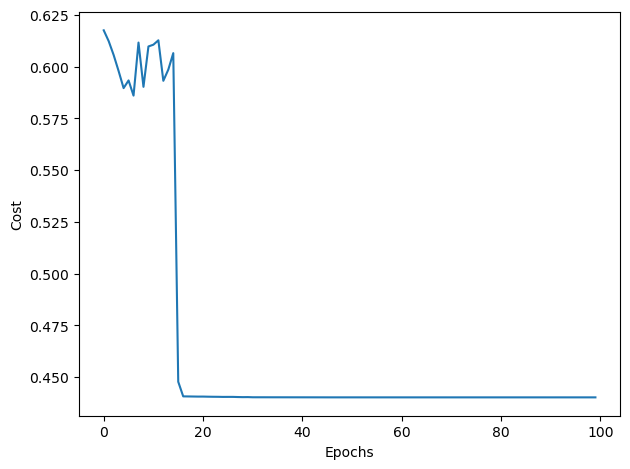

In [17]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()